# Eps-greedy

In [2]:
import numpy as np
import copy
from dataclasses import dataclass

np.set_printoptions(precision=3)

In [3]:
np.zeros(4)

array([0., 0., 0., 0.])

In [4]:
class State:    
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # number of times each arm was chosen
        self.values = np.zeros(n_arms)  # estimate of thetas (the expected reward for each arm)
   
    def __repr__(self):
        return f"counts: {self.counts}\nvalues: {self.values}"

class EpsilonGreedy:
    @classmethod
    def get_arm(cls, state: State, eps: float=0.1) -> int:
        # Decide to either explore or exploit
        if np.random.random() < eps:
            # Explore
            arm = np.random.randint(state.n_arms)
        else:
            # Exploit
            arm = np.argmax(state.values)
        return arm

def update(state: State, arm: int, reward: float) -> State:
    s = copy.deepcopy(state)
    s.counts[arm] += 1
    s.values[arm] = ((s.counts[arm] - 1) * s.values[arm] + reward) / s.counts[arm]
    return s

## Evaluation of EpsilonGreedy

In [5]:

class Utility:
    def __init__(self, thetas: [float]):
        self.thetas = thetas
        
def react(utility: Utility, arm: int) -> float:
    if np.random.random() < utility.thetas[arm]:
        return 1.0
    else:
        return 0

In [6]:
# Evaluation
thetas = [0.30, 0.50, 0.35, 0.60]  # Cycling, Picnic, Climbing, Movie

utility = Utility(thetas)
state = State(len(thetas))
states = [state]
arms = []
rewards = []

num_trials = 1000  # budget

for i in range(num_trials):
    arm = EpsilonGreedy.get_arm(state)
    arms.append(arm)

    reward = react(utility, arm)
    rewards.append(reward)

    state = update(state, arm, reward)
    states.append(state)

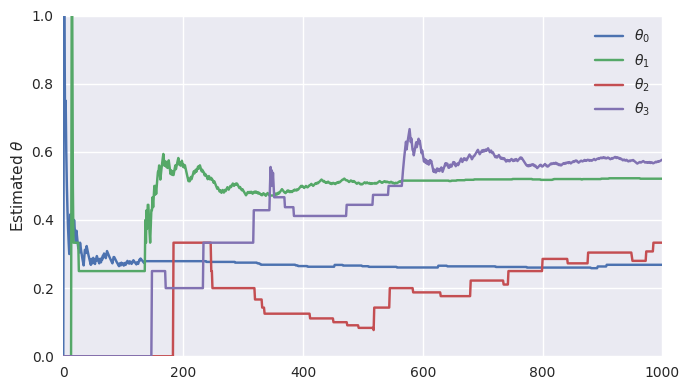

In [7]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

theta_evolution = np.array([s.values for s in states])

# Plot the estimated theta values
for i in range(len(thetas)):
    ax.plot(theta_evolution[:, i], label=r"$\theta_{}$".format(i))

ax.legend()

ax.set_ylabel(r"Estimated $\theta$")

plt.xlim([0, 1000])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

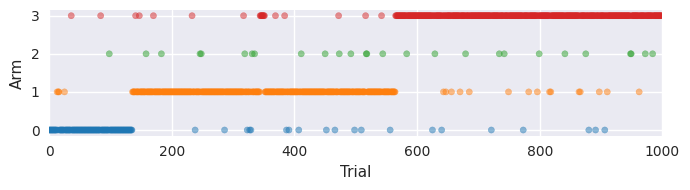

In [8]:
# Plot a scatter plot of which arm was chosen at each time step
arm_index = [0, 1, 2, 3]
arm_labels = ["0", "1", "2", "3"]
arm_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Plot the arm choices

fig, ax = plt.subplots(1, 1, figsize=(7, 2))

ax.scatter(range(num_trials), arms, c=[arm_colors[i] for i in arms], s=20, alpha=0.5)
ax.set_yticks(arm_index, arm_labels)
ax.set_ylabel("Arm")
ax.set_xlabel("Trial")
ax.set_xlim([0, 1000])
plt.tight_layout()
plt.show()

In [9]:
class Oracle:
    @classmethod
    def get_arm(cls, u: Utility) -> int:
        return np.argmax(u.thetas)

opt_rewards = []
for i in range(num_trials):
    arm = Oracle.get_arm(utility)

    reward = react(utility, arm)
    opt_rewards.append(reward)

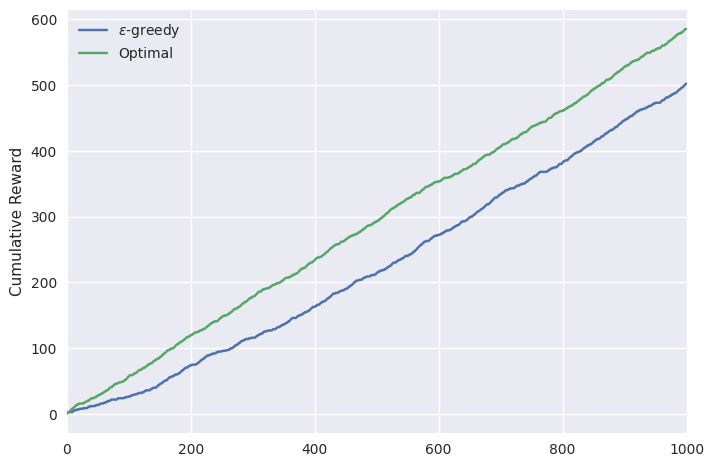

In [10]:
plt.plot(np.cumsum(rewards), label=r"$\epsilon$-greedy")
plt.plot(np.cumsum(opt_rewards), label=r"Optimal")
plt.legend()
plt.ylabel("Cumulative Reward")
plt.xlim([0, 1000])

plt.show()

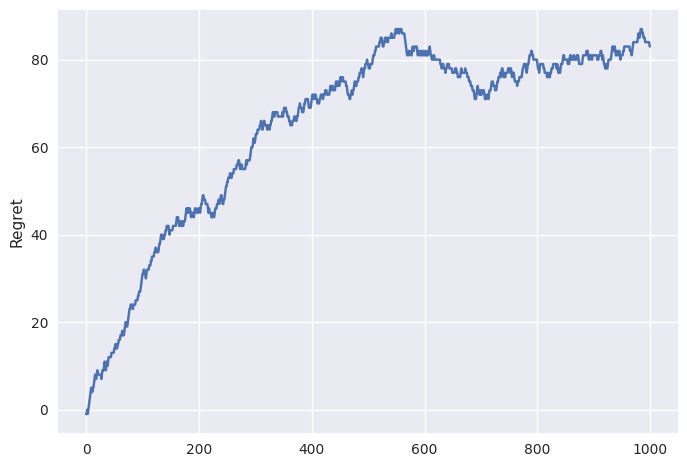

In [11]:
regrets = np.cumsum(opt_rewards) - np.cumsum(rewards)
plt.plot(regrets)
plt.ylabel("Regret")
plt.show()

# Thompson Sampling

In [12]:
class TSState:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

class ThompsonSampling:
    @classmethod
    def get_arm(cls, state: TSState) -> int:
        beta = lambda N, a: np.random.beta(a + 1, N - a + 1)
        dist = [beta(state.counts[i], state.values[i]) for i in range(state.n_arms)]
        arm = dist.index(max(dist))
        return arm

def ts_update(state: TSState, arm: int, reward: float) -> State:
    s = copy.deepcopy(state)
    s.counts[arm] += 1
    s.values[arm] += reward
    return s

In [13]:
for i in range(10):
    print(np.random.beta(1 + 80, 1 + 20)) 


0.8489104876516768
0.8061317572986691
0.8162818001806029
0.7463439280877981
0.7486459927643199
0.8383606419164739
0.7583818211482323
0.7448754668431271
0.7732249081027135
0.8004069857560684


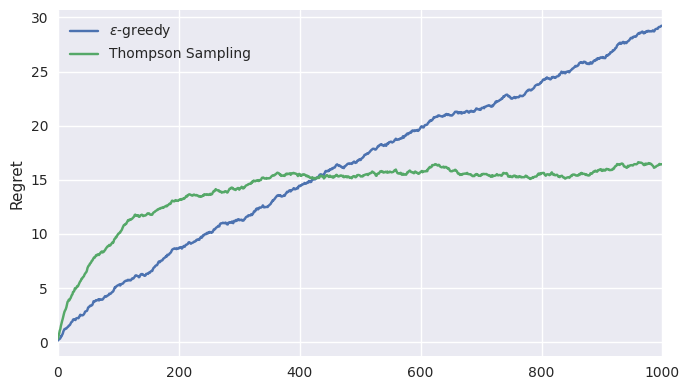

In [14]:
import matplotlib.pyplot as plt

thetas = [0.80, 0.50, 0.35, 0.60]

env = Utility(thetas)

def simulate(num_simulation=100):
    eg_regrets = []
    ts_regrets = []

    for i in range(num_simulation):
        num_trials = 1000

        # Oracle
        opt_rewards = []
        for i in range(num_trials):
            arm = Oracle.get_arm(env)

            reward = react(env, arm)
            opt_rewards.append(reward)

        # Eps-greedy
        eg_state = State(len(thetas))
        eg_rewards = []
        for i in range(num_trials):
            arm = EpsilonGreedy.get_arm(eg_state)
            reward = react(env, arm)
            eg_rewards.append(reward)
            eg_state = update(eg_state, arm, reward)      

        # ThompsonSampling
        ts_state = TSState(len(thetas))
        ts_rewards = []
        for i in range(num_trials):
            arm = ThompsonSampling.get_arm(ts_state)
            reward = react(env, arm)
            ts_rewards.append(reward)
            ts_state = ts_update(ts_state, arm, reward)

        # Calculate regrets
        _eg_regrets = np.cumsum(opt_rewards) - np.cumsum(eg_rewards)
        eg_regrets.append(_eg_regrets)

        _ts_regrets = np.cumsum(opt_rewards) - np.cumsum(ts_rewards)
        ts_regrets.append(_ts_regrets)

    eg_regrets = np.array(eg_regrets)
    ts_regrets = np.array(ts_regrets)
    eg_mean_regrets = np.mean(eg_regrets, axis=0)
    ts_mean_regrets = np.mean(ts_regrets, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(eg_mean_regrets, label=r"$\epsilon$-greedy")
    ax.plot(ts_mean_regrets, label="Thompson Sampling")
    ax.legend()

    ax.set_ylabel("Regret")
    ax.set_xlim([0, 1000])
    plt.tight_layout()
    plt.show()

simulate()